## Image classification with Convolutional Neural Networks

### Real vs. computer generated street view image classifier

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/share/real_vs_cg/"
sz=112

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## Checking the path:

In [9]:
os.listdir(PATH)

['valid', 'train', 'tmp', 'models']

Possible classes:

In [10]:
os.listdir(f'{PATH}valid')

['cg', 'real']

## Using pre-trained ResNet:

In [15]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 63/63 [00:34<00:00,  1.84it/s]


epoch      trn_loss   val_loss   accuracy                     
    0      0.090003   0.117548   0.95525   
    1      0.06144    0.096288   0.96625                      
    2      0.094697   0.084236   0.96775                      



[array([0.08424]), 0.96775]

In [17]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
# from here we know that 'greek' is label 0 and 'international' is label 1.
data.classes

['cg', 'real']

In [19]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(4000, 2)

In [20]:
log_preds[:10]

array([[ -0.     , -12.64049],
       [ -0.00006,  -9.68123],
       [ -0.00019,  -8.5847 ],
       [ -0.00011,  -9.08146],
       [ -0.00002, -10.99645],
       [ -0.00001, -11.82259],
       [ -0.00005,  -9.98397],
       [ -0.00003, -10.30632],
       [ -0.00002, -10.8908 ],
       [ -0.00001, -11.7614 ]], dtype=float32)

In [21]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [22]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [23]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [25]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


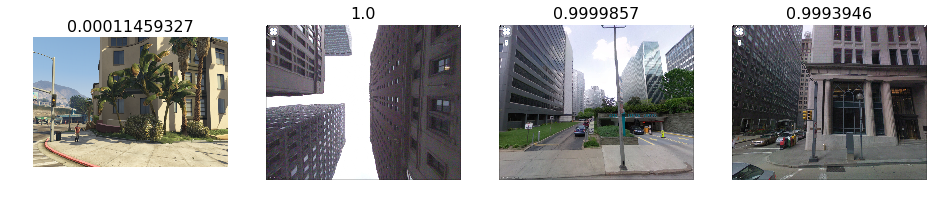

In [26]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


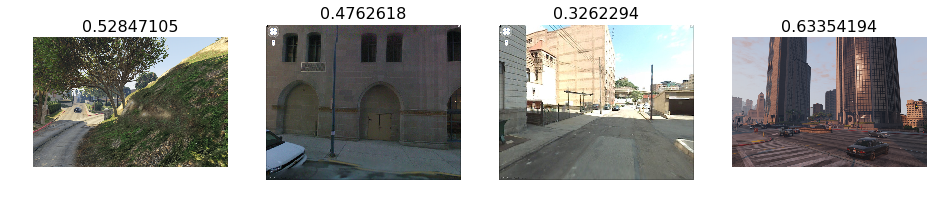

In [27]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [28]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct CG


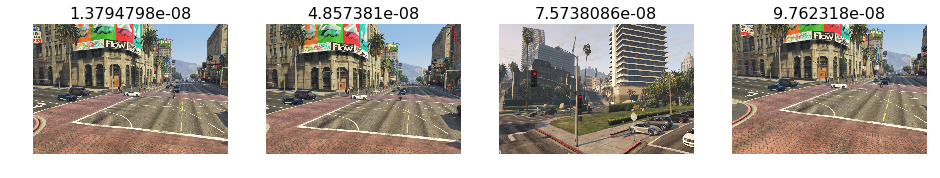

In [30]:
plot_val_with_title(most_by_correct(0, True), "Most correct CG")

Most correct REAL


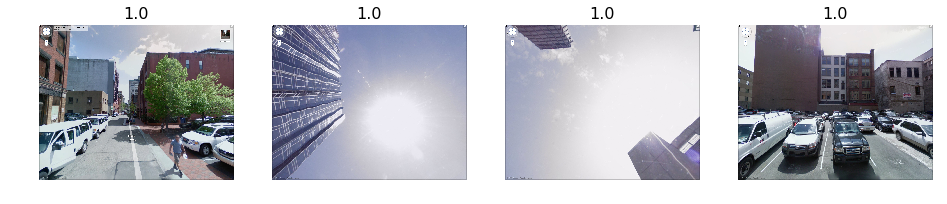

In [31]:
plot_val_with_title(most_by_correct(1, True), "Most correct REAL")

Most incorrect CG


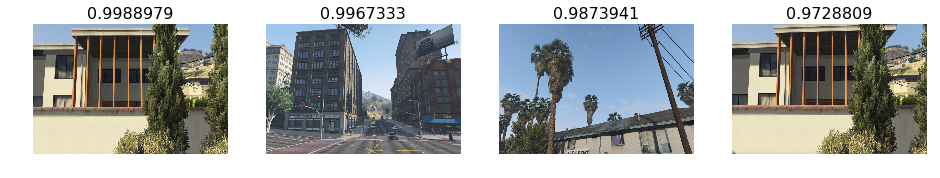

In [33]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect CG")

Most incorrect REAL


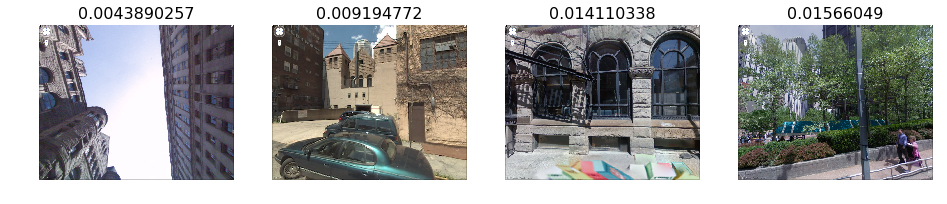

In [34]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect REAL")

Most uncertain predictions


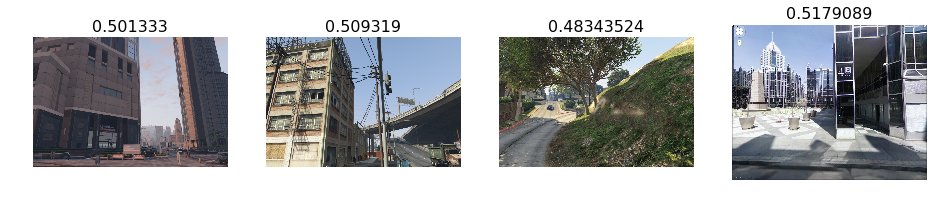

In [35]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Finding a suitable learning rate

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [37]:
lrf=learn.lr_find()

 86%|████████▌ | 197/229 [00:05<00:00, 35.43it/s, loss=1.26] 


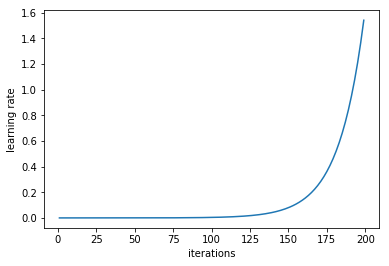

In [38]:
learn.sched.plot_lr()

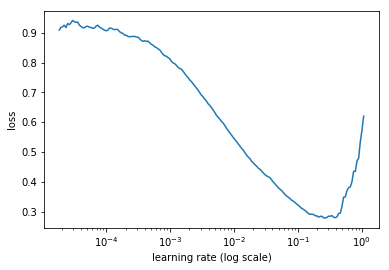

In [39]:
learn.sched.plot()

Best learning rate to choose = 10^-1

## Data augmentation and model improvements:

In [40]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [41]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [42]:
ims = np.stack([get_augs() for i in range(6)])

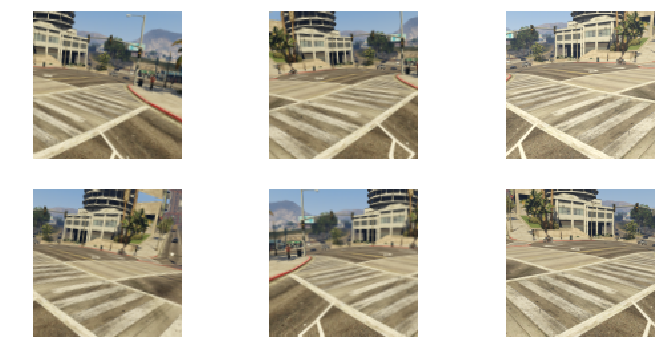

In [43]:
plots(ims, rows=2)

Let's train again Including the new transforms (augmentation):

In [44]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [45]:
learn.fit(1e-1, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.135984   0.141185   0.9655    



[array([0.14119]), 0.9655]

Now let's set pre-compute to false so we don't consider the precomputed activations:

In [46]:
learn.precompute=False

In [47]:
learn.fit(1e-1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.082259   0.114003   0.967     
    1      0.26804    0.129736   0.95575                      
    2      0.253437   0.178503   0.95825                     



[array([0.1785]), 0.95825]

Data augmentation did not improve the accuracy. Possible reason: these aren't images of standard objects, therefore such transformations won't help the model.

Plot learning rate as a function of iterations:

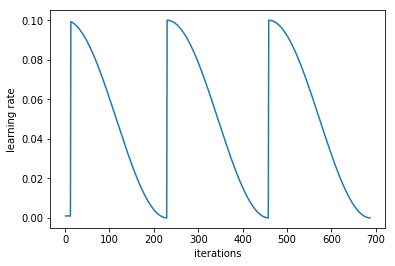

In [49]:
learn.sched.plot_lr()

In [52]:
learn.save('real_vs_cgi_lastlayer')

In [54]:
learn.load('real_vs_cgi_lastlayer')

### Unfreezing the layers, fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [55]:
learn.unfreeze()

We will use different learning rates for different layers: the first few layers will be at 1e-3, the middle layers at 1e-2, and our FC layers we'll leave at 1e-1 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [56]:
lr=np.array([1e-3,1e-2,1e-1])

In [57]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.102524   0.023453   0.9925    
    1      0.018597   0.016778   0.996                        
    2      0.006805   0.010184   0.9975                        
    3      0.541668   0.005765   0.9985                        
    4      0.015181   0.130427   0.986                        
    5      0.01771    0.059141   0.99075                       
    6      0.218847   0.057363   0.99075                      



[array([0.05736]), 0.99075]

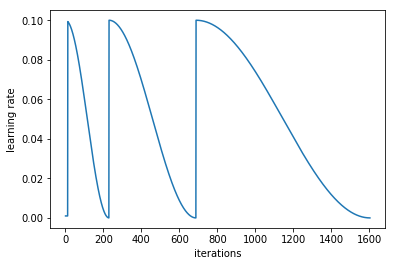

In [58]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-3,1e-2,1e-1])`.

In [59]:
learn.save('real_vs_cg_all')

In [60]:
learn.load('real_vs_cg_all')

## Test Time Augmentation:

In [61]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [62]:
accuracy_np(probs, y)

0.99225

## Confusion matrix 

In [65]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[1997    3]
 [  28 1972]]


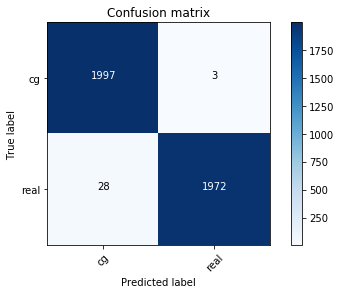

In [67]:
plot_confusion_matrix(cm, data.classes)

Most incorrect CG


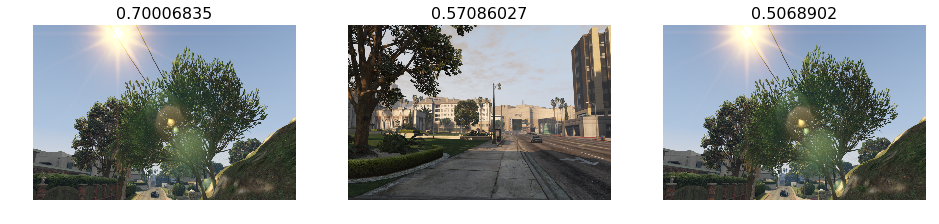

In [69]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect CG")

Most incorrect REAL


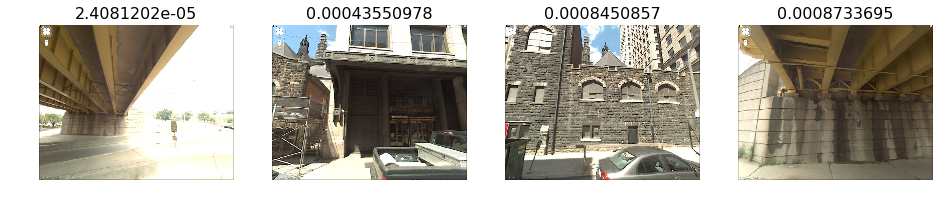

In [70]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect REAL")